Import Necessary Libraries:

In [17]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
import nltk
from nltk.corpus import stopwords
import string
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Download Stopwords
nltk.download('stopwords')
#Load the Dataset
file_path = '/content/HateSpeechDetection (Balanced dataset).csv'
df = pd.read_csv(file_path)
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Platform,Comment,Hateful
0,Reddit,Damn I thought they had strict gun laws in Ger...,0
1,Reddit,I dont care about what it stands for or anythi...,0
2,Reddit,It's not a group it's an idea lol,0
3,Reddit,So it's not just America!,0
4,Reddit,The dog is a spectacular dancer considering he...,0


Data Preprocessing:

In [18]:

# Data Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text


# Apply the preprocessing function to the comments
df['Comment'] = df['Comment'].apply(preprocess_text)
print("Data preprocessing completed.")
print(df.head())


Data preprocessing completed.
  Platform                                           Comment  Hateful
0   Reddit              damn thought strict gun laws germany        0
1   Reddit  dont care stands anything connected like shields        0
2   Reddit                                    group idea lol        0
3   Reddit                                           america        0
4   Reddit  dog spectacular dancer considering two left feet        0


Tokenize and Pad Sequences:

Splits data into features (X) and labels (y).

Tokenizes the text data.

Pads the sequences to a maximum length of 100.

In [19]:
X = df['Comment']
y = df['Hateful']

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_tokenized = tokenizer.texts_to_sequences(X)

max_length = 100
X_padded = pad_sequences(X_tokenized, maxlen=max_length, padding='post')
print("Tokenization and padding completed.")
print(X_padded[:5])


Tokenization and padding completed.
[[ 190  148 2423 1488 1489  581    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   2   57 1071   93 1490    1 2424    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    

Balance the Dataset:
Uses RandomOverSampler to balance the dataset by oversampling the minority class to have 5000 samples per class.


In [20]:
desired_samples_per_class = 5000
sampling_strategy = {0: desired_samples_per_class, 1: desired_samples_per_class}

ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_padded, y)
print("Dataset balanced using RandomOverSampler.")
print("Class distribution after resampling:")
print(pd.Series(y_resampled).value_counts())


Dataset balanced using RandomOverSampler.
Class distribution after resampling:
Hateful
0    5000
1    5000
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (5000) in class 0 will be larger than the number of samples in the majority class (class #0 -> 2400)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (5000) in class 1 will be larger than the number of samples in the majority class (class #0 -> 2400)
  warnings.warn(


Split the Data:

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print("Data split into training and testing sets.")
print(f"Training set size: {len(X_train)}, Testing set size: {len(X_test)}")


Data split into training and testing sets.
Training set size: 8000, Testing set size: 2000


Define the Model:
Defines a Sequential CNN model:

Embedding layer converts words to dense vectors.

Conv1D layer applies convolution operation.

MaxPooling1D layer reduces the dimensionality.

Flatten layer flattens the output.

Dense layers are fully connected layers.

Dropout layer prevents overfitting.

sigmoid activation function is used for binary classification.

In [22]:
embedding_dim = 32  # Embedding dimension
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_length))
cnn_model.add(Conv1D(filters=16, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(1, activation='sigmoid'))
print("Model defined successfully.")
cnn_model.summary()


Model defined successfully.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 32)           198176    
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 16)            2576      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 48, 16)            0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 768)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                24608     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                          

Compile the Model:
Compiles the model using binary_crossentropy loss and Adam optimizer with a learning rate of 0.0001.

In [23]:
optimizer = Adam(learning_rate=0.0001)
cnn_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


Training the Model:
Defines early stopping to prevent overfitting.

Trains the model for 5 epochs with a batch size of 64, using 20% of the training data for validation.

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

cnn_history = cnn_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1, callbacks=[early_stopping])


Epoch 1/5
100/100 [==============================] - 2s 15ms/step - loss: 1.2108 - accuracy: 0.5170 - val_loss: 1.1239 - val_accuracy: 0.5200
Epoch 2/5
100/100 [==============================] - 1s 13ms/step - loss: 1.0553 - accuracy: 0.5427 - val_loss: 0.9926 - val_accuracy: 0.5394
Epoch 3/5
100/100 [==============================] - 1s 12ms/step - loss: 0.9428 - accuracy: 0.6233 - val_loss: 0.8977 - val_accuracy: 0.6681
Epoch 4/5
100/100 [==============================] - 1s 12ms/step - loss: 0.8609 - accuracy: 0.6831 - val_loss: 0.8279 - val_accuracy: 0.7506
Epoch 5/5
100/100 [==============================] - 1s 13ms/step - loss: 0.7982 - accuracy: 0.7516 - val_loss: 0.7714 - val_accuracy: 0.7981


Evaluate the Model:
Evaluates the model on the test set.

Generates predictions and prints a classification report also print cofusion matrix.

63/63 [==============================] - 0s 3ms/step - loss: 0.7705 - accuracy: 0.8150
Test Accuracy: 0.8149999976158142
63/63 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.74      0.98      0.84      1001
           1       0.97      0.65      0.78       999

    accuracy                           0.81      2000
   macro avg       0.85      0.81      0.81      2000
weighted avg       0.85      0.81      0.81      2000



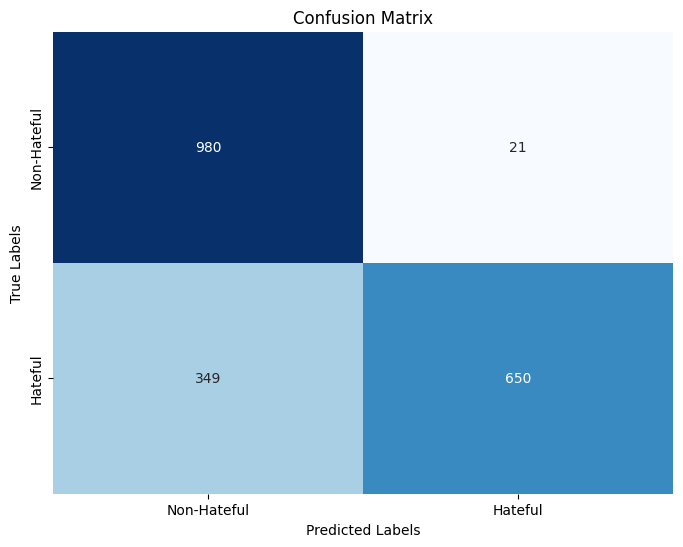

In [25]:
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {cnn_accuracy}')


y_pred = (cnn_model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Hateful', 'Hateful'], yticklabels=['Non-Hateful', 'Hateful'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Modifying the Number of Neurons

To modify the number of neurons, let's change the Dense layer in the model definition and retrain the model:



Epoch 1/5
100/100 [==============================] - 6s 35ms/step - loss: 1.6873 - accuracy: 0.5041 - val_loss: 1.5177 - val_accuracy: 0.5081
Epoch 2/5
100/100 [==============================] - 3s 32ms/step - loss: 1.3842 - accuracy: 0.6020 - val_loss: 1.2624 - val_accuracy: 0.6325
Epoch 3/5
100/100 [==============================] - 3s 27ms/step - loss: 1.1658 - accuracy: 0.6330 - val_loss: 1.0782 - val_accuracy: 0.7731
Epoch 4/5
100/100 [==============================] - 2s 25ms/step - loss: 1.0055 - accuracy: 0.7967 - val_loss: 0.9383 - val_accuracy: 0.8106
Epoch 5/5
63/63 [==============================] - 1s 7ms/step - loss: 0.7965 - accuracy: 0.8980
Test Accuracy: 0.8980000019073486
63/63 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1001
           1       0.91      0.88      0.90       999

    accuracy                           0.90      2000
   macro avg       0.90      0

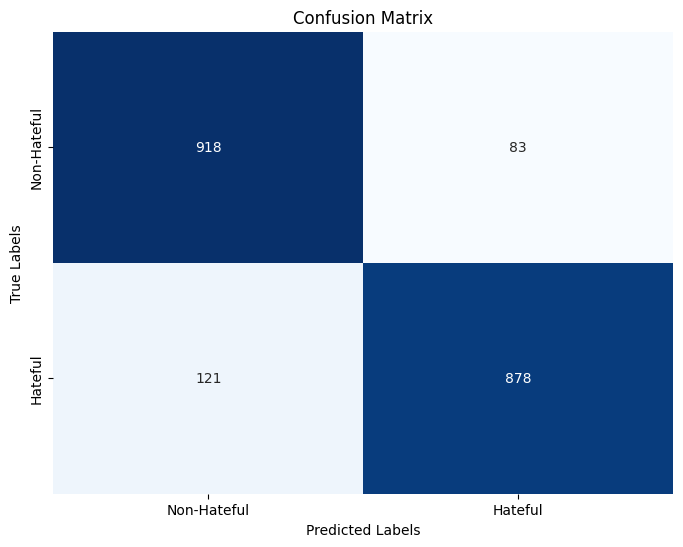

In [26]:
# Define the CNN model with different number of neurons
embedding_dim = 32
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_length))
cnn_model.add(Conv1D(filters=16, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # Increased neurons to 64
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)
cnn_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
cnn_history = cnn_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1, callbacks=[early_stopping])

cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {cnn_accuracy}')

y_pred = (cnn_model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Hateful', 'Hateful'], yticklabels=['Non-Hateful', 'Hateful'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
